In [1]:
!echo Queue: $SLURM_JOB_PARTITION
!echo Node: $SLURMD_NODENAME 
!echo CPUs: $SLURM_CPUS_PER_TASK 
!echo RAM: $SLURM_MEM_PER_GPU

Queue: ml_gpu-rtx2080
Node: mlgpu05
CPUs: 2
RAM:


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import torch
import glob
import time
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import mne
mne.set_log_level("ERROR")
from torch.nn.functional import relu
import braindecode
from braindecode.models.deep4 import Deep4Net
from braindecode.util import set_random_seeds

sys.path.insert(0, "/home/gemeinl/code/patternnet/pytorch_patternnet/")
import layers as patlayers
from util import (forward_pass_for_signal, forward_pass_for_statistics, 
                  create_pattern_layers, backward_pass, get_model_easy, 
                  original_forward, ram_usage)

/home/gemeinl/anaconda3/envs/new_braindecode/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Create network

In [4]:
# network params
n_chans = 21
n_classes = 2
n_start_chans = 25
input_time_length = 6000
n_chan_factor = 2
final_conv_length = 1
stride_before_pool = True
nonlin = relu

In [5]:
# create network
model = Deep4Net(
    n_chans, n_classes,
    n_filters_time=n_start_chans,
    n_filters_spat=n_start_chans,
    input_window_samples=input_time_length,
    n_filters_2=int(n_start_chans * n_chan_factor),
    n_filters_3=int(n_start_chans * (n_chan_factor ** 2.0)),
    n_filters_4=int(n_start_chans * (n_chan_factor ** 3.0)),
    final_conv_length=final_conv_length,
    stride_before_pool=stride_before_pool,
    first_nonlin=nonlin,
    later_nonlin=nonlin)

braindecode.models.util.to_dense_prediction_model(model)
# load params
model.load_state_dict(torch.load(
    '/home/gemeinl/rabea_pathology_deep_with_relu/rabea_pathology_deep_with_relu_state_dict_0.pt',
    map_location='cpu'))
model.eval()

# tested if the same result as with torch.load('model.pt') with 
# torch.all(torch.eq(result1, result2)) --> true

Deep4Net(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=transpose_time_to_spat) 
  (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
  (conv_spat): Conv2d(25, 25, kernel_size=(1, 21), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=relu) 
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False)
  (pool_nonlin): Expression(expression=identity) 
  (drop_2): Dropout(p=0.5, inplace=False)
  (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False)
  (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin_2): Expression(expression=relu) 
  (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(9, 1), ceil_mode=False)
  (pool_nonlin_2): Expression(expression=identity) 
  (drop_3): Dropout(p=0.5, inplace=False)
  (c

In [6]:
cuda = True

# send the model to gpu
if cuda:
    assert torch.cuda.is_available()
    device = "cuda"
    model.cuda()
    torch.backends.cudnn.benchmark = True
else:
    device = "cpu"

In [7]:
set_random_seeds(20200929, cuda)

In [8]:
model_easy = get_model_easy(model)

Ensure4d()
Expression(expression=transpose_time_to_spat) 
LogSoftmax()
Expression(expression=squeeze_final_output) 


In [9]:
model_easy

[Ensure4d(),
 Expression(expression=transpose_time_to_spat) ,
 Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1)),
 Conv2d(25, 25, kernel_size=(1, 21), stride=(1, 1), bias=False),
 BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Expression(expression=relu) ,
 MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False),
 Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False),
 BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Expression(expression=relu) ,
 MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(9, 1), ceil_mode=False),
 Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), dilation=(9, 1), bias=False),
 BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Expression(expression=relu) ,
 MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(27, 1), ceil_mode=False),
 Conv2d(100, 200, kernel_size=(10, 1), 

## New forward model

In [10]:
pattern_layers = create_pattern_layers(model_easy)

No PatternLayer for layer: Ensure4d()
No PatternLayer for layer: Expression(expression=transpose_time_to_spat) 
No PatternLayer for layer: LogSoftmax()
No PatternLayer for layer: Expression(expression=squeeze_final_output) 


In [11]:
subsets = ["normal"]#, "abnormal"]
states = ["clean"]#, "bad"]

for state, subset in product(states, subsets):
    rec_paths_list = glob.glob(f'/home/kiessnek/PatternNet/Tensors_autoreject/{subset}/{state}/' + '**/*-epo.fif', recursive=True)
    print(f"for {subset}, {state} there are {len(rec_paths_list)} recordings")

for normal, clean there are 1371 recordings


In [12]:
stop_rec = 1
stop_batch = None
# i think i understood that we have a batch dimension. rabea was limited to two examples 
# due to memory issues. so she chose one normal and one abnormal example. rtx2080 can 
# actually handle more windows at a time. so lets do it and save some time
n_windows = 16
for rec_i, rec_path in enumerate(rec_paths_list):
    rec_time_start = time.time()
    if rec_i == stop_rec:
        break
    all_windows = mne.read_epochs(rec_path)
    batch_indeces = [np.arange(len(all_windows))[i:i+n_windows] for i in range(0, len(all_windows), n_windows)]
    for batch_i, indeces in enumerate(batch_indeces):
        batch_time_start = time.time()
        if batch_i == stop_batch:
            break
        windows = all_windows[indeces]
        print(f"rec {rec_i} has {len(all_windows)} windows, processing batch {batch_i} as {indeces}")
        test_data = torch.FloatTensor(windows.get_data()[:, :, :, None])
        if cuda:
            test_data = test_data.cuda()
            
        
        out_new, conv_in_outs = forward_pass_for_statistics(model, pattern_layers, test_data)
        #print()
        #out_orig = original_forward(model, test_data)
        # original forward pass and new defined forward pass the same?
        # print(torch.equal(out_new, out_orig))

        ## Compute statistics
        conv_cnt = 0 
        for layer in pattern_layers:
            layerclass = layer.__class__.__name__
            if layerclass == 'PatternConv2d':
                #if layer.forward_layer.dilation != (1,1):
                #    print(layer.forward_layer)
                #    print(conv_in_outs[conv_cnt][0].shape, conv_in_outs[conv_cnt][1].shape)
                #    print(layer.backward_layer)
                #    print()
                layer.compute_statistics(*conv_in_outs[conv_cnt])
                conv_cnt += 1
        

        print(f"batch {batch_i} took {time.time() - batch_time_start}\n")
    print(f"rec {rec_i} took {time.time() - rec_time_start}\n\n")

rec 0 has 117 windows, processing batch 0 as [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
batch 0 took 6.630121231079102

rec 0 has 117 windows, processing batch 1 as [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
batch 1 took 6.359059810638428

rec 0 has 117 windows, processing batch 2 as [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
batch 2 took 6.368902921676636

rec 0 has 117 windows, processing batch 3 as [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
batch 3 took 6.361431121826172

rec 0 has 117 windows, processing batch 4 as [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
batch 4 took 6.369939088821411

rec 0 has 117 windows, processing batch 5 as [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
batch 5 took 6.399646282196045

rec 0 has 117 windows, processing batch 6 as [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
batch 6 took 6.37050199508667

rec 0 has 117 windows, processing batch 7 as [112 113 114 115 116]
batch 7 took 6.00823688507080

## Compute signal

In [13]:
# compute forward pass
out, pools, relus, pool_sizes = forward_pass_for_signal(model, pattern_layers, test_data) 
# compute output with only maximum values
out_tmp = torch.zeros_like(out)
max_v, max_i = torch.max(out.data, dim=1)
# did not find out how to use max_i for indexing, but in this example 
# the first sample always has its maximum at the first value,
# the second sample always has its maximum at the second value
out_tmp[0,0,:] = max_v[0]
out_tmp[1,1,:] = max_v[1]

In [14]:
# now we have the output prepared, so let's move 
# on to the backward pass
signal = backward_pass(pattern_layers, out_tmp, pools[::-1], relus[::-1], pool_sizes[::-1])

/home/gemeinl/code/patternnet/pytorch_patternnet/documentation_notebooks/util.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(out)


In [15]:
print(signal.shape)
print(test_data.shape)

torch.Size([5, 1, 2500, 21])
torch.Size([5, 21, 2500, 1])


In [16]:
sig_min = torch.min(signal).cpu().detach().numpy()
sig_max = torch.max(signal).cpu().detach().numpy()
print(sig_min, sig_max)

test_data_norm = test_data / torch.max(torch.abs(test_data))
print(torch.max(test_data_norm), torch.min(test_data_norm))

-1.0 0.81955767
tensor(1., device='cuda:0') tensor(-0.8449, device='cuda:0')


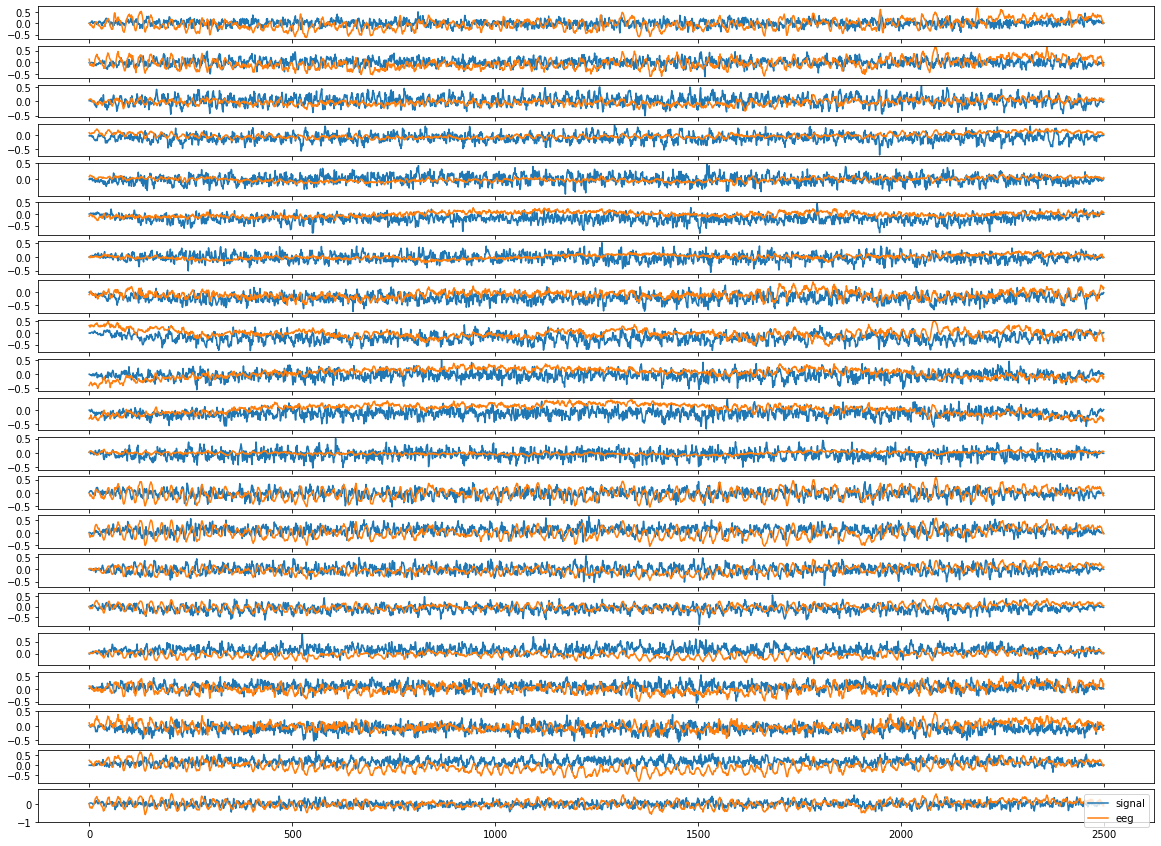

In [17]:
plt.figure(figsize=(20,15))

for i in range(signal.shape[3]):
    plt.subplot(signal.shape[3],1,i+1)
    plt.plot(np.array(signal[0,0,:,i].cpu().detach().numpy()), label='signal')
    plt.plot(np.array(test_data_norm[0,i,:,0].cpu().detach().numpy()), label='eeg')
    
plt.ylim(sig_min, sig_max)
plt.legend()
plt.show()

In [22]:
torch.eq(torch.load("all_detached_cpu.pkl"), torch.load("nothing_detached_cpu.pkl")).all()

tensor(True)